In [1]:
import cudf
import cupy
import matplotlib.pyplot as plt
from cuml.cluster import KMeans as cuKMeans

from cuml.preprocessing import SimpleImputer, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from cuml.ensemble import RandomForestClassifier as cuRF
from sklearn.metrics import accuracy_score

In [2]:
include_cols = ['spkid', 'pha', 'neo', 'H', 'diameter', 'albedo', 'epoch_mjd', 'e', 'a', 'q', 'i', 'om', 'w', 'ma', 'ad', 'n', 'tp', 'tp_cal', 'per', 'per_y', 'moid', 'class', 'rms']
explicit_dtypes = {'spkid': 'int64'}#, 'class': 'category', 'pha': 'category', 'neo': 'category'}
df = cudf.read_csv('~/Downloads/dataset.csv', index_col = 'spkid', usecols = include_cols)#), na_values=cupy.nan, usecols = include_cols, dtype=explicit_dtypes)

df2 = df.dropna(subset=['pha', 'neo'])
pha_new = df2.loc[:, 'pha'].map({'Y': 1, 'N': 0})
neo_new = df2.loc[:, 'neo'].map({'Y':1, 'N':0})
#print(df2['class'].unique())
class_new = df2.loc[:, 'class'].map({'MBA':1, 'OMB':2, 'MCA':3, 'AMO':4, 'IMB':5, 'TJN':6, 'CEN':7, 'APO':8, 'ATE':9, 'AST':10, 'TNO':11, 'IEO':12})
df2.loc[:, 'pha'] = pha_new
df2.loc[:, 'neo'] = neo_new
df2.loc[:, 'class'] = class_new
df2.info()

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 938599 entries, 2000001 to 3246553
Data columns (total 22 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   neo        938599 non-null  object
 1   pha        938599 non-null  object
 2   H          932337 non-null  float64
 3   diameter   136209 non-null  float64
 4   albedo     135103 non-null  float64
 5   epoch_mjd  938599 non-null  int64
 6   e          938599 non-null  float64
 7   a          938599 non-null  float64
 8   q          938599 non-null  float64
 9   i          938599 non-null  float64
 10  om         938599 non-null  float64
 11  w          938599 non-null  float64
 12  ma         938598 non-null  float64
 13  ad         938599 non-null  float64
 14  n          938599 non-null  float64
 15  tp         938599 non-null  float64
 16  tp_cal     938599 non-null  float64
 17  per        938599 non-null  float64
 18  per_y      938599 non-null  float64
 19  moid       938599 non-

In [3]:
!nvidia-smi

Thu Aug 19 21:00:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:2D:00.0  On |                  N/A |
|  0%   42C    P2    55W / 170W |   5330MiB / 12031MiB |     80%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
num_data = df2.select_dtypes(exclude=['category', 'object'])
#print(num_data.columns)
imp_num = SimpleImputer(strategy='mean', missing_values=cupy.nan)
imp_data = imp_num.fit_transform(num_data)
imp_data.columns = num_data.columns
imp_data.index = df2.index
imp_data.head(10)
#imped_num = imp_num.transform(num_data)

#imp_num_data = cudf.DataFrame(data=imp_data, index=df2.index, columns=num_data.columns)
#imp_num_data.info()

,H,diameter,albedo,epoch_mjd,e,a,q,i,om,w,ma,ad,n,tp,tp_cal,per,per_y,moid,rms
spkid,,,,,,,,,,,,,,,,,,,
2000001,3.40,939.400,0.0900,58600.0,0.076009,2.769165,2.558684,10.594067,80.305531,73.597695,77.372098,2.979647,0.213885,2.458239e+06,2.018043e+07,1683.145703,4.608202,1.594780,0.43301
2000002,4.20,545.000,0.1010,59000.0,0.229972,2.773841,2.135935,34.832932,173.024741,310.202392,144.975675,3.411748,0.213345,2.458321e+06,2.018072e+07,1687.410992,4.619880,1.234290,0.35936
2000003,5.33,246.596,0.2140,59000.0,0.256936,2.668285,1.982706,12.991043,169.851482,248.066193,125.435355,3.353865,0.226129,2.458446e+06,2.018112e+07,1592.013769,4.358696,1.034290,0.33848
2000004,3.00,525.400,0.4228,58600.0,0.088721,2.361418,2.151909,7.141771,103.810804,150.728541,95.861938,2.570926,0.271609,2.458248e+06,2.018051e+07,1325.432763,3.628837,1.139480,0.39980
2000005,6.90,106.699,0.2740,59000.0,0.190913,2.574037,2.082619,5.367427,141.571026,358.648418,17.846343,3.065455,0.238661,2.458926e+06,2.020032e+07,1508.414421,4.129814,1.095750,0.52191
2000006,5.80,185.180,0.2679,59000.0,0.203219,2.424533,1.931822,14.739653,138.643432,239.736273,190.686496,2.917243,0.261073,2.459649e+06,2.022031e+07,1378.924506,3.775290,0.973673,0.41032
2000007,5.60,199.830,0.2766,59000.0,0.230145,2.387375,1.837933,5.521598,259.563943,145.201545,247.425811,2.936818,0.267192,2.459422e+06,2.021073e+07,1347.347071,3.688835,0.850693,0.38128
2000008,6.50,147.491,0.2260,59000.0,0.155833,2.201415,1.858362,5.889081,110.876524,285.458915,315.318013,2.544467,0.301753,2.459149e+06,2.020103e+07,1193.029574,3.266337,0.875980,0.54186
2000009,6.30,190.000,0.1180,59000.0,0.123300,2.386189,2.091972,5.576494,68.909459,6.337325,23.912204,2.680407,0.267391,2.458911e+06,2.020030e+07,1346.343282,3.686087,1.107110,0.44895


In [5]:
# Preprocessing Start
# Set random seed
# Separate values X and y.
cat_data = df2.select_dtypes(include='object')
le = LabelEncoder()
cat_data2 = cudf.DataFrame()
for i in ['neo', 'pha', 'class']:
    encoded = le.fit_transform(cat_data[i])
    encoded = encoded
    cat_data2[i] = encoded.astype('float64')
#at_data2.info()
#print(imp_data.index)
df3 = cudf.merge(imp_data, cat_data2, left_index=True, right_index=True)
df3.info()

<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 938599 entries, 2001377 to 3989397
Data columns (total 22 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   H          938599 non-null  float64
 1   diameter   938599 non-null  float64
 2   albedo     938599 non-null  float64
 3   epoch_mjd  938599 non-null  float64
 4   e          938599 non-null  float64
 5   a          938599 non-null  float64
 6   q          938599 non-null  float64
 7   i          938599 non-null  float64
 8   om         938599 non-null  float64
 9   w          938599 non-null  float64
 10  ma         938599 non-null  float64
 11  ad         938599 non-null  float64
 12  n          938599 non-null  float64
 13  tp         938599 non-null  float64
 14  tp_cal     938599 non-null  float64
 15  per        938599 non-null  float64
 16  per_y      938599 non-null  float64
 17  moid       938599 non-null  float64
 18  rms        938599 non-null  float64
 19  neo        938599 

In [6]:
y = df3.pop('pha')
#code.fit_transform(y)
X = df3
feats = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train.describe(), y_test.describe()

(count    750879.000000
 mean          0.002197
 std           0.046825
 min           0.000000
 25%           0.000000
 50%           0.000000
 75%           0.000000
 max           1.000000
 Name: pha, dtype: float64,
 count    187720.000000
 mean          0.002216
 std           0.047023
 min           0.000000
 25%           0.000000
 50%           0.000000
 75%           0.000000
 max           1.000000
 Name: pha, dtype: float64)

In [7]:
model_outputs = {}
def get_pred(model_func, x, y, x_t):
  model = model_func.fit(x, y)
  y_predicted = model.predict(x_t)
  return y_predicted

In [8]:
from cuml.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter = 1000)
model_outputs['logreg'] = model_outputs.get('logreg', get_pred(logreg, X_train, y_train, X_test))

[21:00:11] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1623267594558/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


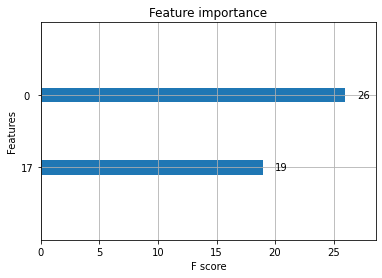

In [9]:
import xgboost as xgb
from xgboost import plot_importance
xgbmodel = xgb.XGBClassifier(objective='binary:logistic', booster='gbtree', tree_method='gpu_hist', n_estimators=10, max_depth=3, random_state=100, use_label_encoder=False)
model_outputs['xgb'] = model_outputs.get('xgb', get_pred(xgbmodel, X_train, y_train, X_test))

plot_importance(xgbmodel)
plt.show()

In [10]:
from tensorflow.python.client import device_lib
import tensorflow as tf
print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16398874888142829549
]
Num GPUs Available:  0


In [11]:
from cuml.metrics import log_loss
model_log_loss=[]
for key, value in model_outputs.items():
  model_log_loss.append([key, log_loss(y_true = y_test, y_pred = value)])

model_log_loss_sorted = sorted(model_log_loss, key = lambda model: model[1])

print("Cross-Entropy by Model, Low to High")
for model in model_log_loss_sorted:
  print(f"{model[0]}: {model[1]}")

Cross-Entropy by Model, Low to High
xgb: 0.008463582538706957
logreg: 0.0653171020114965
